## 02_Prédire les variations de vitesse
Objectif: prédire la vitesse à court terme (t + Δt) pour indiquer au coureur si sa vitesse va monter ou baisser bientôt. La prédiction se fait sur les données de : 
- Fréquence cardiaque, 
- Vitesse de courses, 
- Distance déjà parcourue, 
- Distance totale de course
A l'instant t (qui représente des données disponibles sur une montre connectée) 

Nous utilisons un ESN (Echo State Network) avec les mêmes bibliothèques que dans le notebook 01.

Nous chargeons les courses, créons des séquences d'entraînement, normalisons les données, entraînons l’ESN, puis évaluons les prédictions de vitesse à t + Δt.

In [34]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy import ESN
import glob
import re

In [35]:
# Fixer la graine pour reproductibilité
rpy.set_seed(42)

### Préparation des données d'entraînement
Nous chargeons les fichiers CSV, ordonnons les courses et construisons les séquences. La cible `y` est ici la vitesse future au temps t + Δt. Pour chaque course, nous alignons les entrées `X` à l’instant t avec la vitesse à l’instant t + Δt, afin de prédire des variations proches du temps réel.

In [36]:
# Chargement des données (courses 4 à 9 pour l'entraînement)
data_dir = "../projet_data/data"
files = glob.glob(f"{data_dir}/course*.csv")

def course_idx(path):
    m = re.search(r"course(\d+)\.csv", path)
    return int(m.group(1)) if m else 1e9

files = sorted(files, key=course_idx)
train_files = files[3:9]
print("Fichiers d'entraînement:", [f.split("/")[-1] for f in train_files])

X_train_list_raw = []
y_train_list_raw = []

for fp in train_files:
    df = pd.read_csv(fp, sep=';', decimal=',').fillna(0)
    df["Time"] = pd.to_datetime(df["Time"])
    df["t_elapsed"] = (df["Time"] - df["Time"].iloc[0]).dt.total_seconds()
    total_time = df["t_elapsed"].iloc[-1]
    df["time_remaining"] = total_time - df["t_elapsed"]
    km_total = df["km"].iloc[-1]
    df["km_total"] = km_total

    Xi = df[["km", "speed_kmh", "FC", "km_total"]].values
    yi = df["time_remaining"].values.reshape(-1, 1)

    delta_t = 30
  # nombre de pas dans le futur

    X_train_list_raw.append(Xi[:-delta_t])
    y_train_list_raw.append(Xi[delta_t:, 1].reshape(-1, 1))

print("Nombre de courses entraînement:", len(X_train_list_raw))

Fichiers d'entraînement: ['data\\course4.csv', 'data\\course5.csv', 'data\\course6.csv', 'data\\course7.csv', 'data\\course8.csv', 'data\\course9.csv']
Nombre de courses entraînement: 6


### Normalisation des séquences
Nous appliquons une mise à l’échelle simple (0–1) en divisant chaque variable par son maximum sur l’entraînement. 

In [37]:
# Normalisation simple (0-1) sur l'ensemble d'entraînement
X_concat = np.vstack(X_train_list_raw)
y_concat = np.vstack(y_train_list_raw)

X_max = X_concat.max(axis=0)
y_max = y_concat.max()

Xn_train_list = [Xi / X_max for Xi in X_train_list_raw]
Yn_train_list = [yi / y_max for yi in y_train_list_raw]

### Définition du modèle ESN
Nous initialisons l'ESN avec des paramètres pour le moment non optimisés, que nous retravaillerons ensuite pour rendre le modèle plus adapté. 

In [38]:
# Création du réservoir
reservoir = Reservoir(units=100, lr=0.5, sr=0.9)
readout = Ridge(ridge=1e-7)
esn_model = reservoir >> readout


### Entraînement avec période de warmup
Nous entraînons l’ESN sur les séquences normalisées avec un `warmup` pour laisser le réservoir se stabiliser. Le readout apprend à partir des états internes à prédire la vitesse future à t + Δt.

In [39]:
# Entraînement sur listes de séquences
warmup = 30
esn_model = esn_model.fit(Xn_train_list, Yn_train_list, warmup=warmup)

print("Reservoir initialized:", reservoir.initialized)
print("Readout initialized:", readout.initialized)

Reservoir initialized: True
Readout initialized: True


### Prétraitement et inférence sur la course de test
Pour tester, nous appliquons le même prétraitement que pour l’entraînement et normalisons avec les maxima d’entraînement. Après `reset()`, nous lançons `run` pour obtenir la vitesse prédite à t + Δt et la remettons à l’échelle d’origine.

In [40]:
# Prédiction sur une course de test (non vue)
# Utilise la 12e course
test_file = files[11] if len(files) > 8 else train_files[-1]
print("Fichier de test:", test_file.split("/")[-1])

test_df = pd.read_csv(test_file, sep=';', decimal=',').fillna(0)
test_df["Time"] = pd.to_datetime(test_df["Time"])
test_df["t_elapsed"] = (test_df["Time"] - test_df["Time"].iloc[0]).dt.total_seconds()
total_time_test = test_df["t_elapsed"].iloc[-1]
test_df["time_remaining"] = total_time_test - test_df["t_elapsed"]
km_total_test = test_df["km"].iloc[-1]
test_df["km_total"] = km_total_test

X_test_raw = test_df[["km", "speed_kmh", "FC", "km_total"]].values

X_test_n = X_test_raw / X_max

esn_model.reset()
y_pred_n = esn_model.run(X_test_n[:-delta_t])
y_pred = y_pred_n * y_max
y_real = X_test_raw[delta_t:, 1].reshape(-1,1)
print("Shapes pred/real:", len(y_pred), len(y_real))

Fichier de test: data\course12.csv
Shapes pred/real: 3537 3537


### Visualisation et interprétation
Nous traçons la vitesse réelle à t + Δt et la vitesse prédite correspondante. Les premiers points sont ignorés via `warmup` (moins fiables). Le décalage de Δt est pris en compte pour aligner correctement les courbes.

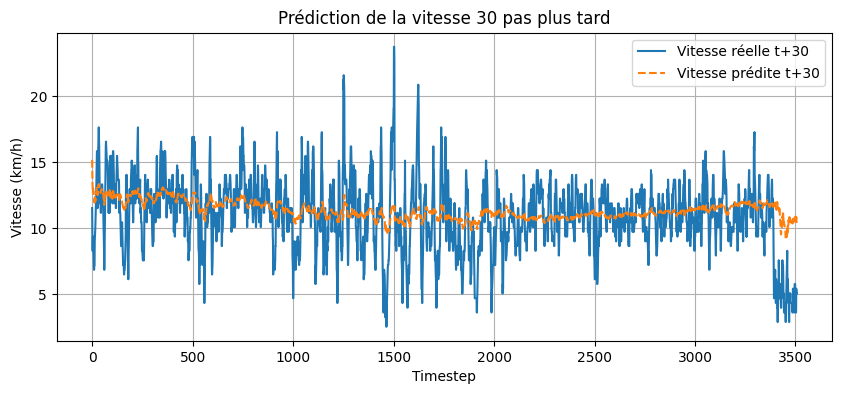

In [41]:
start = warmup
# Définition des indices sécurisés
real_start = max(start - delta_t, 0)
end_common = min(len(y_pred), len(y_real) - real_start, len(y_pred) - start)
n = end_common

if n <= 0:
    print(f"Pas assez de points pour tracer (delta_t={delta_t}, warmup={warmup}).")
else:
    plt.figure(figsize=(10,4))

    y_real_shifted = y_real[real_start : real_start + n]
    y_pred_slice = y_pred[start : start + n]

    plt.plot(y_real_shifted, label=f"Vitesse réelle t+{delta_t}")
    plt.plot(y_pred_slice, "--", label=f"Vitesse prédite t+{delta_t}")
    plt.xlabel("Timestep")
    plt.ylabel("Vitesse (km/h)")
    plt.title(f"Prédiction de la vitesse {delta_t} pas plus tard")
    plt.legend()
    plt.grid(True)
    plt.show()


In [42]:
diff = y_pred - X_test_raw[:-delta_t, 1].reshape(-1,1)
direction = np.where(diff > 0, "↑", "↓")  # ↑ = augmentation, ↓ = baisse

# Exemple
t = 1156
t = min(t, len(direction)-1)
print(f"t={t} : v_actuelle={X_test_raw[t,1]:.1f} km/h, v_prévue(t+{delta_t})={y_pred[t,0]:.1f} km/h, direction prédite = {direction[t]}")

t=1156 : v_actuelle=11.5 km/h, v_prévue(t+30)=10.9 km/h, direction prédite = ['↓']


### Analyse 
On voit que pour une prédiction entre 10sec et 30sec, la tendance de vitesse est plutôt bien retrouvée, avec tout de meme un lissage des variations rapides. Elle permet ainsi d'estimer les variations de vitesse. Cela peut être utile pour faire un feedback au coureur qui est en train de courir, pour le prévenir des éventuelle baisses ou hausses de régime anticipées à cour terme, pour corriger sa vitesse. 

30sec est un bon compromis pour laisser le temps au coureur de prendre en compte l'information, corriger sa vitesse en fonction des performance qu'il souhaite faire, sans pour autant être victime des variations très rapides à cour terme qui pourrait totalement le biaiser dans son ajustement. 

On voit que pour une prédiction à court terme, comme sur la figure pour t+1sec, la prédiction suit bien les variations réelles, tandis que pour une prédication à plus long terme comme t+5min, la courbe de prédiction est nettement plus lissée, laissant disparaitre les variations rapides et locales.

Ce comportement est lié à la structure même de l’ESN : le réservoir prédit la vitesse en se basant à la fois sur le présent et sur ce qui s’est passé juste avant, donc à court terme il peut suivre les petites variations, mais plus on regarde loin dans le futur, plus les détails s’effacent et seule la tendance générale reste visible. Ainsi, les variations brutales ne sont plus prédites, comme la fin du signal sur la dernière figure ci-dessous. 

Cela peut être amélioré en jouant sur les paramètres du réservoir, ce que nous faisons dans le notebook suivant.


![Comparaison t+1sec](./images/image1.png)
![Comparaison t+10min](./images/image3.png)
![Comparaison t+30min](./images/image4.png)
![Comparaison t+5min](./images/image2.png)